In [15]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [16]:
from IPython.core.debugger import set_trace

from pathlib import Path
import json
from matplotlib import patches, patheffects
from scipy.special import expit

from fastai.conv_learner import *
from fastai.dataset import *



In [17]:
#pycharm plotting
plt.ion()

In [18]:
#TODO symlink data to Data/fastai
PATH = Path('..')/'data/pascal/pascal_direct')
JPEGS = 'train/VOC2007/JPEGImages/'
IMG_PATH = PATH/JPEGS

In [19]:
#images: is list of {file_name, height, width, id}
#annotations:[{"segmentation":[[155,96,155,270,351,270,351,96]],"area":34104,"iscrowd":0,"image_id":12,"bbox":[155,96,196,174],"category_id":7,"id":1,"ignore":0}
#categories:[{"supercategory":"none","id":1,"name":"aeroplane"}
trn_j = json.load((PATH / 'pascal_train2007.json').open())

In [20]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [21]:
trn_j[CATEGORIES][:2]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'}]

In [22]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
#eg {1: 'aeroplane', 2: 'bicycle',
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
#eg {12: '000012.jpg', 17: '000017.jpg',
trn_ids = [o[ID] for o in trn_j[IMAGES]]
#eg[12, 17, 23, 

In [23]:
first_image = trn_j[IMAGES][0]
print(f'file_name: {first_image[FILE_NAME]}, id: {first_image[ID]}')

file_name: 000012.jpg, id: 12


In [24]:
trn_anno = collections.defaultdict(lambda:[])
#"annotations":[{"segmentation":[[52,86,52,420,471,420,471,86]],"area":139946,"iscrowd":0,"image_id":2008000008,"bbox":[52,86,419,334],"category_id":13,"id":1,"ignore":0},
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

In [25]:
#trn_anno is a dict of {id, [(bbox, category_id), ...]} where coords are now TL, BR and numpy consistent x,y coords
im_a = trn_anno[first_image[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [26]:
im_0a = im_a[0]

In [27]:
#conversion between numpy style and cs style
def bb_hw(a): 
    return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [28]:
im = open_image(IMG_PATH/first_image[FILE_NAME])

In [29]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [30]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [31]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [32]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [33]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [34]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

## Largest Item Classifier

In [35]:
def get_lrg(b):
    if not b: 
        raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [36]:
#b[0]: (array([ 96, 155, 269, 350]), 7), b[0][-2:]: (array([ 96, 155, 269, 350]), 7), b[0][:2]: (array([ 96, 155, 269, 350]), 7)
#b[0]: (array([ 96, 155, 269, 350]), 7), b[0][0]: [ 96 155 269 350], b[0][:2]: (array([ 96, 155, 269, 350]), 7)


In [37]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

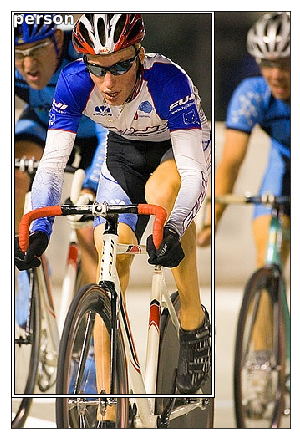

<Figure size 432x288 with 0 Axes>

In [38]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)
plt.show()
plt.savefig('temp.png')

In [39]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [40]:
print(PATH)


/mnt/samsung_1tb/Data/fastai/pascal/pascal_direct


In [41]:
df = pd.DataFrame({'filename': [trn_fns[o] for o in trn_ids],
                  'category': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns = ['filename', 'category'])
df.to_csv(CSV, index=False)

In [42]:
df.head(n=2)

,filename,category
0,000012.jpg,car
1,000017.jpg,horse


In [43]:
f_model = resnet34
size = 224
bs = 64

In [44]:
transforms = tfms_from_model(f_model, sz=size, aug_tfms=transforms_side_on, crop_type = CropType.NO)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=transforms)

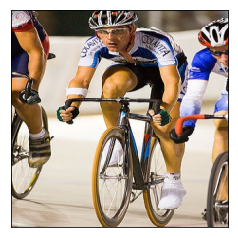

In [45]:
#grab a single batch, x is independent, y is dependent variable
x, y = next(iter(model_data.val_dl))
#need to convert x to numpy array

show_img(model_data.val_ds.denorm(to_np(x))[0])


In [46]:
learn = ConvLearner.pretrained(f_model, model_data, metrics=[accuracy])
#torch.optim has various optimization algos
learn.opt_fn = optim.Adam

In [47]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:04<00:00,  6.08it/s, loss=12.5]


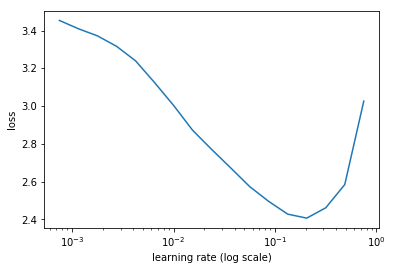

In [48]:
#looks weird if dont set n_skip_end as by default we remove first and last few points ie:
#plot(self, n_skip=10, n_skip_end=5)
learn.sched.plot(n_skip_end=2)

In [49]:
lr = 1e-1

In [50]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      2.539368   1.330018   0.757212  



[1.3300182, 0.7572115361690521]

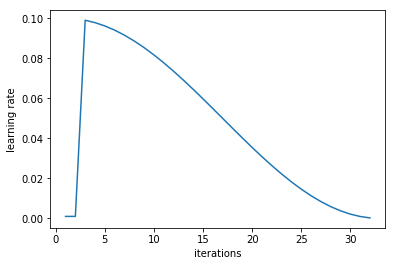

In [51]:
learn.sched.plot_lr()

In [52]:
x, y 
#print(f'{layer_groups}, {len(layer_groups)}')


(
 ( 0 , 0 ,.,.) = 
   3.9125e-01  4.3014e-01  4.8172e-01  ...   1.7518e-01  3.2367e-01  4.0783e-01
   5.1636e-01  4.4973e-01  5.9202e-01  ...   1.7386e-01  2.3164e-01  3.6722e-01
   5.4416e-01  5.7267e-01  7.0099e-01  ...   5.7682e-02  2.2320e-01  3.5455e-01
                  ...                   ⋱                   ...                
   1.4604e+00  1.5029e+00  1.5195e+00  ...   7.8030e-01  5.6716e-01 -6.3922e-01
   9.3739e-01  1.0210e+00  1.1599e+00  ...   1.1281e+00  1.0895e+00  4.5857e-01
   5.8584e-01  4.5245e-01  2.9605e-01  ...   1.0003e+00  9.2495e-01  8.2729e-01
 
 ( 0 , 1 ,.,.) = 
   2.4041e-01  3.1444e-01  4.1422e-01  ...   3.3162e-01  4.7052e-01  5.4764e-01
   3.9737e-01  4.2156e-01  5.7304e-01  ...   3.3887e-01  3.8799e-01  5.2038e-01
   5.2462e-01  5.8245e-01  6.7485e-01  ...   2.5190e-01  4.0003e-01  5.1502e-01
                  ...                   ⋱                   ...                
   1.4721e+00  1.5019e+00  1.5077e+00  ...   6.0917e-01  4.4337e-01 -7.3978e-01


In [53]:
#final layer, set lr to 1e-1, ~50/50 split of lr for prev layers
lrs = np.array([lr/1000, lr/100, lr])

In [54]:
learn.freeze_to(-2)

In [55]:
lrf = learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:05<00:01,  4.66it/s, loss=8.69]


In [56]:
#Was getting an error when LayerOptimizer checks that len(layer_groups) is = len(lrs)as have one layer group (TODO check if lr_find fixed this)
learn.fit(lrs=lrs/5, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.754232   1.146259   0.77494   



[1.1462592, 0.7749399021267891]

In [57]:
#In layer_optimizer we can (re)set the lrearning rates
#first we need to initialize the optimizer
#could do this: var_iter = next(iter(model_data.val_dl)) but we need Varibles not FloatTensors
#opt_adam = optim.Adam(params = VV(x), lr = lr)
#set_lrs(opt_adam, lrs=lrs)

In [58]:
learn.unfreeze()

In [59]:
learn.fit(lrs=lrs/5, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.276218   1.014918   0.789964  



[1.0149181, 0.7899639457464218]

In [60]:
learn.save('clas_one')
learn.load('clas_one')

In [61]:
x, y = next(iter(model_data.val_dl))
x[0]


( 0 ,.,.) = 
  3.9125e-01  4.3014e-01  4.8172e-01  ...   1.7518e-01  3.2367e-01  4.0783e-01
  5.1636e-01  4.4973e-01  5.9202e-01  ...   1.7386e-01  2.3164e-01  3.6722e-01
  5.4416e-01  5.7267e-01  7.0099e-01  ...   5.7682e-02  2.2320e-01  3.5455e-01
                 ...                   ⋱                   ...                
  1.4604e+00  1.5029e+00  1.5195e+00  ...   7.8030e-01  5.6716e-01 -6.3922e-01
  9.3739e-01  1.0210e+00  1.1599e+00  ...   1.1281e+00  1.0895e+00  4.5857e-01
  5.8584e-01  4.5245e-01  2.9605e-01  ...   1.0003e+00  9.2495e-01  8.2729e-01

( 1 ,.,.) = 
  2.4041e-01  3.1444e-01  4.1422e-01  ...   3.3162e-01  4.7052e-01  5.4764e-01
  3.9737e-01  4.2156e-01  5.7304e-01  ...   3.3887e-01  3.8799e-01  5.2038e-01
  5.2462e-01  5.8245e-01  6.7485e-01  ...   2.5190e-01  4.0003e-01  5.1502e-01
                 ...                   ⋱                   ...                
  1.4721e+00  1.5019e+00  1.5077e+00  ...   6.0917e-01  4.4337e-01 -7.3978e-01
  8.4169e-01  9.4566e-01

In [62]:
#model.eval() Sets the module in evaluation mode - batchnorm and dropout are disabled
#self.training is set to False
#predict batch converts x to Variable
batch_preds = predict_batch(learn.model, x)


In [63]:
batch_preds  #bs by classes tensor

Variable containing:
-27.4232  -6.6285 -19.5975  ...  -14.1214 -23.0457 -24.9245
-19.7487 -10.6924 -19.8557  ...   -0.0273 -20.0529 -10.9656
-27.8597 -27.3948   0.0000  ...  -28.3461 -28.3848 -29.1158
           ...               ⋱              ...            
-19.5769 -16.2352 -16.7367  ...   -5.4263 -19.9644 -13.7213
-22.8814 -10.7661 -17.9418  ...  -13.7642 -18.4769 -17.1098
-21.0341 -23.5285 -21.9817  ...  -21.5092 -20.3374 -22.3492
[torch.cuda.FloatTensor of size 64x20 (GPU 0)]

In [64]:
#compute along the class dimension, setting dim to -1 (as per lecture), None or 1 all prod same result
probs = F.softmax(batch_preds, -1)
probs

Variable containing:
 1.2310e-12  1.3222e-03  3.0825e-09  ...   7.3650e-07  9.8033e-11  1.4977e-11
 2.6501e-09  2.2718e-05  2.3811e-09  ...   9.7308e-01  1.9549e-09  1.7286e-05
 7.9562e-13  1.2665e-12  1.0000e+00  ...   4.8916e-13  4.7059e-13  2.2655e-13
                ...                   ⋱                   ...                
 3.1467e-09  8.8953e-08  5.3872e-08  ...   4.3995e-03  2.1359e-09  1.0988e-06
 1.1554e-10  2.1102e-05  1.6143e-08  ...   1.0527e-06  9.4531e-09  3.7095e-08
 7.3283e-10  6.0491e-11  2.8409e-10  ...   4.5568e-10  1.4708e-09  1.9673e-10
[torch.cuda.FloatTensor of size 64x20 (GPU 0)]

In [65]:
x = to_np(x)
preds = to_np(probs)


In [66]:
#get indices of max values (returns the indices of the maximum values along an axis.)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


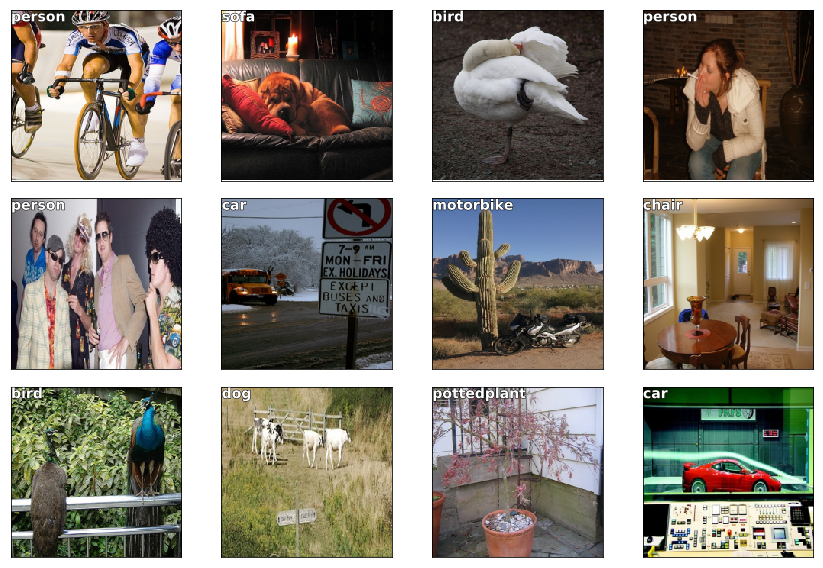

In [67]:
#draw the predictions
fig, axes = plt.subplots(3, 4, figsize = (12, 8))
for i,ax in enumerate(axes.flat):
    ima=model_data.val_ds.denorm(x)[i]
    b = model_data.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0, 0), b)
plt.tight_layout()
plt.show()

In [68]:
#lecture 9 start reviews this part of lecture 8

### Bbox only

In [69]:

#create a model data object for bboxes
#create a model data object for classses
#combine these into one model

In [70]:
BB_CSV = PATH/'tmp/bb.csv'


In [71]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
#want space sep data
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [72]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [73]:
#define architecture
f_model = resnet34
sz = 224
bs = 64

In [74]:
#lighting is image-average*b + c
augs = [RandomFlip(), RandomRotate(20), RandomLighting(b=0.1, c=0.1)]
augs

In [75]:
tfms = tfms_from_model(f_model=f_model, sz=sz, aug_tfms=augs)
#classifiers are categorical, here doing regression
# if continuous=True then label_arr = np.array([np.array(csv_labels[i]).astype(np.float32) for i in fnames])
model_data = ImageClassifierData.from_csv(PATH, JPEGS, csv_fname=BB_CSV, bs=bs, tfms = tfms, continuous=True)

b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]


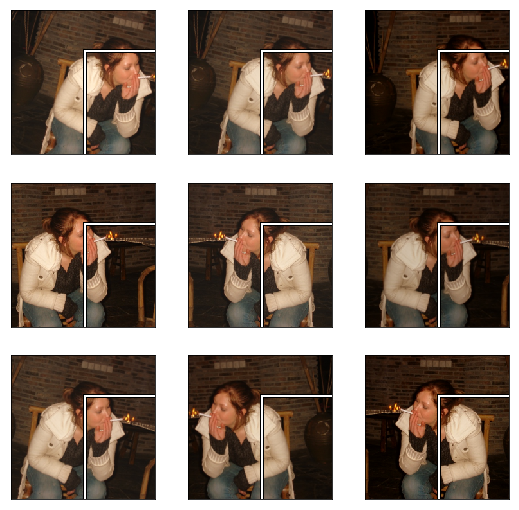

In [76]:
#draw images and bboxes - note problems with bbox locations - need to transform this in same way as indeprendant var
idx=3
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x,y = next(iter(model_data.aug_dl))
    ima = model_data.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(f'b {b}')
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [77]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        #I havent set tfm_y for lighting - I assume wont have any impact
        RandomLighting(0.1,0.1)]

In [78]:
#tfm_y: y axis specific transformations
tfms = tfms_from_model(f_model, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, csv_fname=BB_CSV, bs=64, tfms=tfms)
model_data

In [ ]:

idx=3
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x,y = next(iter(model_data.aug_dl))
    ima = model_data.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    #TODO fix bug with b coordinates
    print(f'b {b}')
    show_img(ima, ax=ax)
    draw_rect(ax, b)

b [0. 0. 0. 0.]
b [0. 0. 0. 0.]
b [0. 0. 0. 0.]
b [0. 0. 0. 0.]
b [0. 0. 0. 0.]
b [0. 0. 0. 0.]
b [0. 0. 0. 0.]


In [ ]:
#now we create a model where we rotate 50% of the time 9 mins on video
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        #rotate up to 3% 50% of time
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05, 0.05, tfm_y=tfm_y)]

In [ ]:
tfms = tfms_from_model(f_model, sz,aug_tfms=augs, crop_type=CropType.NO, tfm_y=tfm_y)
#path, folder, csv_fname, bs=64, tfms
model_data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, bs=bs, tfms=tfms, continuous=True)

In [ ]:
#learn.summary()

#...
#Conv2d-119',
#BatchNorm2d-120',
#'ReLU-121',
#'BasicBlock-122',
#end of convolutional section - where head will be put

In [ ]:
#create a custom head, 512*7*7 = 25088. 4 bounding box coords
#Dont want to add standard fully connected layers that make up a classifier, want a single linear with 4 outputs
#flattens out, this is a simple final layer. 25088=512x7x7
head_reg4 = nn.Sequential(Flatten(), nn.Linear(in_features=25088, out_features=4))
#custom head wont create any of the fully connected network, wont add the adaptive average pooling, instead will add the model you specify
#note that f_model is resnet34
#stick this on a pretrained model
learn = ConvLearner.pretrained(f_model, data = model_data, custom_head=head_reg4)
learn.opt_fn = optim.Adam
#L1 Loss function minimizes the absolute differences between the estimated values and the target values
learn.crit = nn.L1Loss()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 2e-3

In [ ]:
learn.fit(lr, n_cycle=2, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np.array([lr/100, lr/10, lr])
layer_groups = learn.get_layer_groups()

In [ ]:
groups_freeze_to = layer_groups[-2:]
#groups_freeze_to


In [ ]:
#why not just freeze last group?
learn.freeze_to(-2)

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(lrs, 1, cycle_len=2)

In [ ]:
learn.save('reg4')
learn.load('reg4')

In [ ]:
x, y = next(iter(model_data.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ima = model_data.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()


## Single object detection


In [ ]:
#bounding box and largest object
f_model = resnet34
sz = 224
bs = 64


In [ ]:
#Workflow:

#create two models
#md as bbox coords
#md2 as classes
#then merge as a new dataset class

In [ ]:
#note here we are passing in to the ModelData val_idx
#trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
#get indexes for a validations set (80/20 default split); index of images to be used for validation
val_idxs = get_cv_idxs(len(trn_fns))

In [ ]:
tfms = tfms_from_model(f_model,sz=sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
#BB_CSV contains only filename, bbox coords
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, bs=bs, tfms=tfms, continuous=True, val_idxs=val_idxs)
print(f'{type(md)}, size: {md.sz}')

In [ ]:
tfms2 = tfms_from_model(f_model, sz=sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
#note we are reading in the CSV not BB_CSV, CSV contains only filename, category
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs=bs, tfms=tfms2)
md2.sz

In [ ]:
#ImageClassifierData <-ImageData (has own proerties eg sz which returns self.trn_ds.sz) <-ModelData (has own properties eg trn_ds which returns self.trn_dl.dataset)
#but ConcatLblDataset has none of these properties as extends pytorch Dataset directly

In [ ]:
class ConcatLblDataset(Dataset):
    #take existing ds which has existing independent and dependant vars, add in dependent y2
    #extends torch Dataset, which requires one to override the methods below
    #sz property added as is required by learner (lean.summary())
    def __init__(self, ds, ds2):
        #I changed this to use seconds dataset rater than just y to help me understand this
        self.ds = ds
        self.ds2 = ds2
        
    def __len__(self):
        assert len(self.ds) == len(self.ds2)
        return len(self.ds)

    def __getitem__(self, i):
        x, y = self.ds[i]
        x2, y2 = self.ds2[i]
        #these should contain exactly the same info, so we only need to keep one. However this test fails
        #assert np.array_equal(x,x2)
        return (x, (y, y2))
    
    @property
    def sz(self):
        x, y = self.ds[0]
        print(f'sz: {x.shape[1]}')
        return x.shape[1]

In [ ]:
#the bbox tagets
md.trn_ds.y

In [ ]:
#classification dependent variable
md2.trn_ds.y

In [ ]:
#NB I changed the ConcatLblDataset. now it takes two datasets
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_ds)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_ds)

In [ ]:
val_ds2[0][1]

In [ ]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2
print(f'{type(md)}')
#Note that now in ImageData self.trn_ds.sz is no longer a valid property

In [ ]:
x, y = next(iter(md.val_dl))
idx=3
ima = md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

In [ ]:
ax = show_img(ima)
draw_rect(ax,b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])
plt.show()

In [ ]:
#replace head, similar to before but add an extra linear layer and add dropout
head_reg4 = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    #this is a helper linear layer
    nn.Linear(in_features=512*7*7, out_features=256),
    nn.ReLU(),
    #1d as we have flattened 
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    #note at this stage we only have 256 in_features
    nn.Linear(in_features=256, out_features= 4+len(cats))
)


In [ ]:
#ConvnetBuilder(f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None)
#why is c (final layer size) zero, shouldn't it be 4+len(cats)?
model_arch = ConvnetBuilder(f=f_model, c=0, is_multi=False, is_reg=False, custom_head=head_reg4)

In [ ]:
learn = ConvLearner(data = md, models = model_arch)

In [ ]:
learn.opt_fn = optim.Adam

In [ ]:
#loss fn needs to look at 4+C activations & decide if good
#for 4 coords - L1 loss which is like MSE but sums abs vals
#for C use cross-entropy loss
def detn_loss(input, target):
    bb_t, c_t = target
    #first dim is batch dim, input first 4, and 4 onwards elements
    bb_i, c_i = input[:, :4], input[:, 4:]
    #for bb_i we know they will be b/w 0 & 224
    #use sigmoid to force b/w 0&1 and force the range
    bb_i = F.sigmoid(bb_i)*224
    #scalar for classifications based on what works
    combined_loss = F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20
    return combined_loss
    
def detn_l1(input, target):
    bb_t, _ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    f1_loss = F.l1_loss(V(bb_i), V(bb_t)).data
    return f1_loss

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:,4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]
    

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=2e-2
#use_clr sets shed to use CircularLR
learn.fit(lrs=lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

In [ ]:
learn.save('reg1_0')

In [ ]:
#as we replaced the dataset with a ConcatLblData, we no longer have access to .sz property and learn.summary() throws an error, sz prperty added to ConcatLblData above

In [ ]:
#learn.summary()

In [ ]:
layer_groups = learn.get_layer_groups()
print(f'{layer_groups}, {len(layer_groups)}')

In [ ]:
#set to trainable the last two layer groups only 
learn.freeze_to(-2) 

In [ ]:
#learn.sched.plot() cant run as CircularLR has no attribute plot

In [ ]:
#learn.sched.plt_lr() ditto

In [ ]:
lrs = np.array([lr/100, lr/10, lr])

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [ ]:
learn.fit(lrs/5, n_cycle=1, cycle_len=5, use_clr=(32,10))

In [ ]:
learn.save('reg1_1')

In [ ]:
learn.load('reg1_1')

In [ ]:
learn.unfreeze()

In [ ]:
#to plot need to access lrs (ie from declr. above) and losses (tricky, need to work this out), cant plot below as 'CircularLR' object has no attribute 'plot'

In [ ]:
#learn.sched.plot()

In [ ]:
learn.fit(lrs=lrs/10, n_cycle=1, cycle_len=10, use_clr=(32, 10))

In [ ]:
learn.save('reg1')

In [ ]:
learn.load('reg1')

In [ ]:
preds = learn.predict()
x, _ = next(iter(md.val_dl))

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    #val_ds is val_dl.dataset but val_ds.ds?, 
    #.denorm is a method in FilesDataset where we reverse the normalization done to a batch of images
    ima = md.val_ds.ds.denorm(to_np(x))[i]
    #module scipy.special._ufuncs: The expit function, also known as the logistic function, is defined as
    #expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function
    print(f'preds[i][:4]: {preds[i][:4]}')
    bb = expit(preds[i][:4])*224
    print(f'bb: {bb}')
    b = bb_hw(bb)
    c = np.argmax(preds[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()